In [1]:
import sys

# To check required packages
packages_required = {
    "fenics-dolfinx": "dolfinx",
    "cffi": "cffi",
    "fenics-ffcx": "fenics-ffcx",
    "UFL": "UFL",
    "Basix": "Basix",
    "mpi4py": "mpi4py",
    "nanobind": "nanobind",
    "numpy": "numpy",
    "scikit-build-core": "scikit_build",
    "matplotlib": "matplotlib",
    "scipy": "scipy",    
}

print("Python version:", sys.version)
for package_name, import_name in packages_required.items():
    try:
        pkg = __import__(import_name)
        print(f"{package_name} is installed. Version: {pkg.__version__}")
    except ImportError:
        print(f"{package_name} is NOT installed.")

# To check optional packages
packages_optional = {
    "petsc4py": "petsc4py",
    "numba": "numba",
    "pyamg": "pyamg",
    "pyvista": "pyvista",
    "slepc4py": "slepc4py",
}

for package_name, import_name in packages_optional.items():
    try:
        pkg = __import__(import_name)
        print(f"{package_name} is installed. Version: {pkg.__version__}")
    except ImportError:
        print(f"{package_name} is NOT installed.")

Python version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
fenics-dolfinx is NOT installed.
cffi is installed. Version: 1.17.1
fenics-ffcx is NOT installed.
UFL is NOT installed.
Basix is NOT installed.
mpi4py is installed. Version: 3.1.6
nanobind is NOT installed.
numpy is installed. Version: 1.21.5
scikit-build-core is NOT installed.
matplotlib is installed. Version: 3.5.1
scipy is installed. Version: 1.8.0
petsc4py is installed. Version: 3.19.6
numba is NOT installed.
pyamg is NOT installed.
pyvista is NOT installed.
slepc4py is installed. Version: 3.19.2


In [2]:
'''
Python version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]
fenics-dolfinx is NOT installed.
cffi is installed. Version: 1.17.1
fenics-ffcx is NOT installed.
UFL is NOT installed.
Basix is NOT installed.
mpi4py is installed. Version: 3.1.6
nanobind is NOT installed.
numpy is installed. Version: 1.21.5
scikit-build-core is NOT installed.
matplotlib is installed. Version: 3.5.1
scipy is installed. Version: 1.8.0
petsc4py is installed. Version: 3.19.6
numba is NOT installed.
pyamg is NOT installed.
pyvista is NOT installed.
slepc4py is installed. Version: 3.19.2
'''

'\nPython version: 3.10.12 (main, Nov 20 2023, 15:14:05) [GCC 11.4.0]\nfenics-dolfinx is NOT installed.\ncffi is installed. Version: 1.17.1\nfenics-ffcx is NOT installed.\nUFL is NOT installed.\nBasix is NOT installed.\nmpi4py is installed. Version: 3.1.6\nnanobind is NOT installed.\nnumpy is installed. Version: 1.21.5\nscikit-build-core is NOT installed.\nmatplotlib is installed. Version: 3.5.1\nscipy is installed. Version: 1.8.0\npetsc4py is installed. Version: 3.19.6\nnumba is NOT installed.\npyamg is NOT installed.\npyvista is NOT installed.\nslepc4py is installed. Version: 3.19.2\n'

In [3]:
import math
import numpy as np
import matplotlib.pyplot as plt
from dolfin import (RectangleMesh,
                    FiniteElement,
                    triangle,
                    FunctionSpace,
                    Function,
                    TestFunction,
                    TrialFunction,
                    Constant,
                    grad,
                    variable,
                    sym,
                    tr,
                    diff,
                    CellDiameter,
                    FacetNormal,
                    inner,
                    outer,
                    jump,
                    avg,
                    dS,
                    SubDomain,
                    DirichletBC,
                    dx,
                    derivative,
                    assemble_system,
                    PETScLUSolver,
                    XDMFFile,
                    Point,
                    PointSource,
                    Identity,
                    sqrt,
                    project,
                    near,
                    MeshFunction)

import os
import datetime

# Create a folder to store the results, using the current date and time
now = datetime.datetime.now()
results_folder = f"Results_{now.strftime('%Y-%m-%d_%H-%M-%S')}"
os.makedirs(results_folder, exist_ok=True)

# Define the dimensions of the specimen in millimeters
specimen_width_mm = 1000
specimen_height_mm = 1000

# Convert the dimensions to meters
specimen_width = specimen_width_mm/1000
specimen_height = specimen_height_mm/1000
t = Constant(0.004) # Define the thickness of the plate (in meters)

# Define material properties (Young's modulus and Poisson's ratio)
E = Constant(2.1e11) # Young's modulus (Pa)
nu = Constant(0.3) # Poisson's ratio

# Define the element size for the mesh
element_size = 0.01

# Calculate the number of elements in the x and y directions
num_elem_x = round(specimen_width/element_size)
num_elem_y = round(specimen_height/element_size)

# Create a rectangular mesh
mesh = RectangleMesh(Point(0.0, 0.0), Point(specimen_width, specimen_height), num_elem_x, num_elem_y)

# Define the finite element space (Lagrange elements of order 2)
element_W = FiniteElement("Lagrange", triangle,  2)
W = FunctionSpace(mesh, element_W)

# Define functions and test functions for the variational formulation
w_ = Function(W) # Function to store the solution (displacement)
w = TrialFunction(W) # Trial function
w_t = TestFunction(W) # Test function

# Define the gradient of the displacement
theta = grad(w_)
# Define the curvature tensor
k = variable(sym(grad(theta)))

# Define the bending stiffness
D = (E*t**3)/(24.0*(1.0 - nu**2))
# Define the bending strain energy density
psi_M = D*((1.0 - nu)*tr(k*k) + nu*(tr(k))**2)

# Define the bending moment tensor
M = diff(psi_M, k)

# Define the penalty parameter for the CDG method
alpha = E*t**3
# Define the cell diameter
h = CellDiameter(mesh)
# Define the average cell diameter across an interior facet
h_avg = (h('+') + h('-'))/2.0

# Define the facet normal
n = FacetNormal(mesh)

# Define the normal bending moment
M_n = inner(M, outer(n, n))

# Define the CDG term for the variational formulation
L_CDG = -inner(jump(theta, n), avg(M_n))*dS + \
           (1.0/2.0)*(alpha('+')/h_avg)*inner(jump(theta, n), jump(theta, n))*dS

# Define SubDomains for each edge
class LeftEdge(SubDomain):
    def inside(self, x, on_boundary):
        # Returns True if the point x is on the left edge
        return near(x[0], 0.0) and on_boundary

class RightEdge(SubDomain):
    def inside(self, x, on_boundary):
        # Returns True if the point x is on the right edge
        return near(x[0], specimen_width) and on_boundary

class BottomEdge(SubDomain):
    def inside(self, x, on_boundary):
        # Returns True if the point x is on the bottom edge
        return near(x[1], 0.0) and on_boundary

class TopEdge(SubDomain):
    def inside(self, x, on_boundary):
        # Returns True if the point x is on the top edge
        return near(x[1], specimen_height) and on_boundary

# Create instances of SubDomains
left_edge = LeftEdge()
right_edge = RightEdge()
bottom_edge = BottomEdge()
top_edge = TopEdge()

# Mark each edge with a unique tag using MeshFunction
boundary_parts = MeshFunction("size_t", mesh, mesh.topology().dim()-1)
boundary_parts.set_all(0) # Initialize all boundary facets to 0
left_edge.mark(boundary_parts, 1) # Mark left edge with tag 1
right_edge.mark(boundary_parts, 2) # Mark right edge with tag 2
bottom_edge.mark(boundary_parts, 3) # Mark bottom edge with tag 3
top_edge.mark(boundary_parts, 4) # Mark top edge with tag 4

# Define Boundary Conditions (w = 0 for now, can be modified)
bc_left = DirichletBC(W, Constant(0.0), boundary_parts, 1) # Fixed (w=0) on the Left Edge
bc_right = DirichletBC(W, Constant(0.0), boundary_parts, 2) # Fixed (w=0) on the Right Edge
bc_bottom = DirichletBC(W, Constant(0.0), boundary_parts, 3) # Fixed (w=0) on the Bottom Edge
bc_top = DirichletBC(W, Constant(0.0), boundary_parts, 4) # Fixed (w=0) on the Top Edge

# Combine all Boundary Conditions into a list
bcs = [bc_left, bc_right, bc_bottom, bc_top]

# Load Conditions setting
total_force = 153460.0  # Total force (N) applied to the plate
load_width = 0.381  # Loading area width (m)
load_height = 0.381  # Loading area height (m)

# Pressure center coordinate iteration
specimen_center_x = specimen_width/2 # Center x-coordinate of the specimen
specimen_center_y = specimen_height/2 # Center y-coordinate of the specimen

# Define the loading zone boundaries
LoadingZone_start_x = int(math.ceil(load_width/2*10))/10
LoadingZone_start_y = int(math.ceil(load_height/2*10))/10
LoadingZone_end_x = int(specimen_width*10-math.ceil(load_width/2*10))/10
LoadingZone_end_y = int(specimen_height*10-math.ceil(load_width/2*10))/10
LoadingSpacing = 0.1 # Spacing between loading points



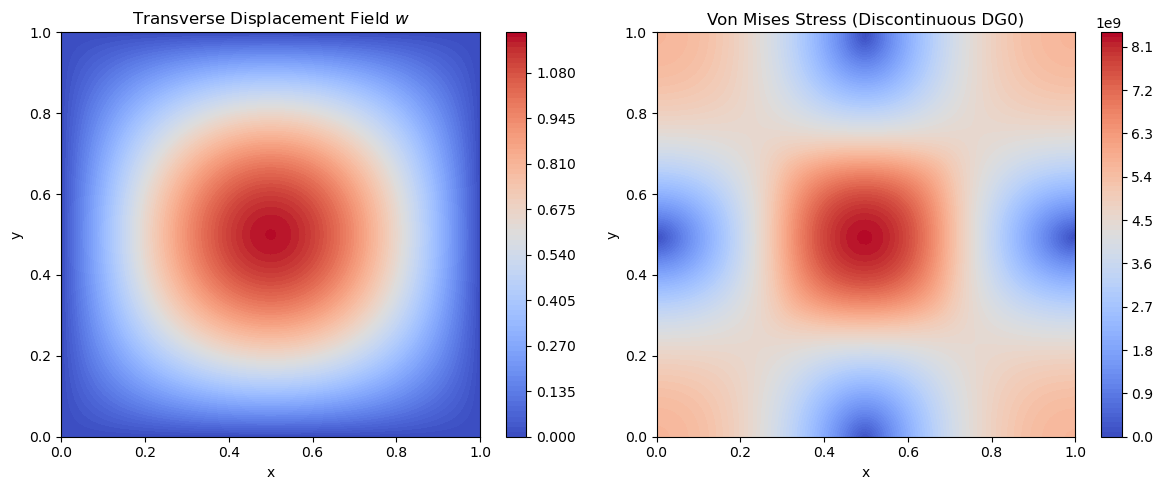

Saved Results_2025-04-14_14-21-53/VonMises_X_0_500-Y_0_500.jpg
Done


In [4]:
# Create arrays of x and y coordinates for the loading points
#x_coords_1 = np.around(np.arange(specimen_center_x, LoadingZone_end_x, LoadingSpacing), decimals=2)
#x_coords_2 = np.around(np.arange(specimen_center_x - LoadingSpacing, LoadingZone_start_x, -1 * LoadingSpacing), decimals=3)
#x_coords = np.concatenate((x_coords_1, x_coords_2))
#x_coords = np.sort(x_coords).tolist()
#y_coords_1 = np.around(np.arange(specimen_center_y, LoadingZone_end_y, LoadingSpacing), decimals=2)
#y_coords_2 = np.around(np.arange(specimen_center_y - LoadingSpacing, LoadingZone_start_y, -1 * LoadingSpacing), decimals=3)
#y_coords = np.concatenate((y_coords_1, y_coords_2))
#y_coords = np.sort(y_coords).tolist()
x_coords = [0.5]
y_coords = [0.5]

# Get mesh coordinates and cell connectivity (moved outside the loop)
coords = mesh.coordinates()
cells = mesh.cells()

# Iterate over the loading points
for pressure_center_x in x_coords:
    for pressure_center_y in y_coords:
        # Define Loading Area SubDomain
        class LoadArea(SubDomain):
            def inside(self, x, on_boundary):
                # Returns True if the point x is within the loading area
                return (pressure_center_x - load_width/2.0 <= x[0] <= pressure_center_x + load_width/2.0 and
                        pressure_center_y - load_height/2.0 <= x[1] <= pressure_center_y + load_height/2.0)

        load_area = LoadArea()

        # Find vertices within the loading area
        vertex_values = W.tabulate_dof_coordinates() # Get the coordinates of all vertices
        load_vertices = []
        for i in range(vertex_values.shape[0]):
            x = vertex_values[i, :] # Get the coordinates of the i-th vertex
            if load_area.inside(x, False): # Check if the vertex is within the loading area (on_boundary is False)
                load_vertices.append(i) # Add the vertex index to the list of loading vertices

        # Calculate the force applied to each vertex
        if load_vertices:
            point_force = total_force / len(load_vertices) # Distribute the total force evenly among the loading vertices
        else:
            point_force = 0.0

        # Apply PointSource to each vertex within the loading area
        point_sources = []
        for vertex_index in load_vertices:
            x = vertex_values[vertex_index, :] # Get the coordinates of the vertex
            pt = Point(x[0], x[1]) # Create a Point object for the vertex
            ps = PointSource(W, pt, point_force) # Create a PointSource object at the vertex with the calculated force
            point_sources.append(ps) # Add the PointSource to the list

        # Define the total potential energy
        L = psi_M*dx + L_CDG

        # Derive the variational form and the Jacobian
        F = derivative(L, w_, w_t)
        J = derivative(F, w_, w)

        # Assemble the system matrix and the right-hand side vector, applying the boundary conditions
        A, b = assemble_system(J, -F, bcs=bcs)

        # Apply the point sources to the right-hand side vector
        for ps in point_sources:
            ps.apply(b)

        # Solve the linear system using a direct solver (MUMPS)
        solver = PETScLUSolver("mumps")
        solver.solve(A, w_.vector(), b)

        # Calculate and save Von Mises stress
        I = Identity(2) # Define the identity tensor
        theta_sol = grad(w_) # Calculate the gradient of the displacement
        k_sol = sym(grad(theta_sol)) # Calculate the curvature tensor
        M_sol = 2*D*((1.0 - nu)*k_sol + nu*tr(k_sol)*I) # Calculate the bending moment tensor

        # Calculate the Von Mises stress expression
        von_mises_expr = (6.0/t**2)*sqrt( M_sol[0,0]**2 - M_sol[0,0]*M_sol[1,1] + M_sol[1,1]**2 + 3*M_sol[0,1]**2 )

        # Project the Von Mises stress onto a DG0 space
        V0 = FunctionSpace(mesh, "DG", 0)
        von_mises = project(von_mises_expr, V0)

        # Create image file name (fill with zeros)
        x_str = f"{pressure_center_x:.3f}".replace('.', '_') # Format the x-coordinate as a string
        y_str = f"{pressure_center_y:.3f}".replace('.', '_') # Format the y-coordinate as a string
        filename = f"VonMises_X_{x_str}-Y_{y_str}.jpg" # Create the filename
        filepath = os.path.join(results_folder, filename) # Create the full file path

        # --- Create a figure with two subplots side by side ---
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

        # --- Displacement Plot (Left Subplot) ---
        plt.sca(axes[0])  # Select the first subplot
        displacement_vertex = w_.compute_vertex_values(mesh)
        plt.tricontourf(coords[:,0], coords[:,1], cells, displacement_vertex, 100, cmap='coolwarm')
        plt.colorbar()
        plt.title("Transverse Displacement Field $w$")
        plt.xlabel("x")
        plt.ylabel("y")

        # --- Von Mises Stress Plot (Right Subplot) ---
        plt.sca(axes[1])  # Select the second subplot
        von_mises_vertex = von_mises.compute_vertex_values(mesh)
        plt.tricontourf(coords[:,0], coords[:,1], cells, von_mises_vertex, 100, cmap='coolwarm')
        plt.colorbar()
        plt.title("Von Mises Stress (Discontinuous DG0)")
        plt.xlabel("x")
        plt.ylabel("y")

        plt.tight_layout() # Adjust the layout
        plt.savefig(filepath) # Save the figure to a file
        plt.show() # Display the figure
        plt.close() # Prevent memory leak by closing the figure

        print(f"Saved {filepath}") # Print the file path

print("Done") # Print a message indicating that the simulation is complete



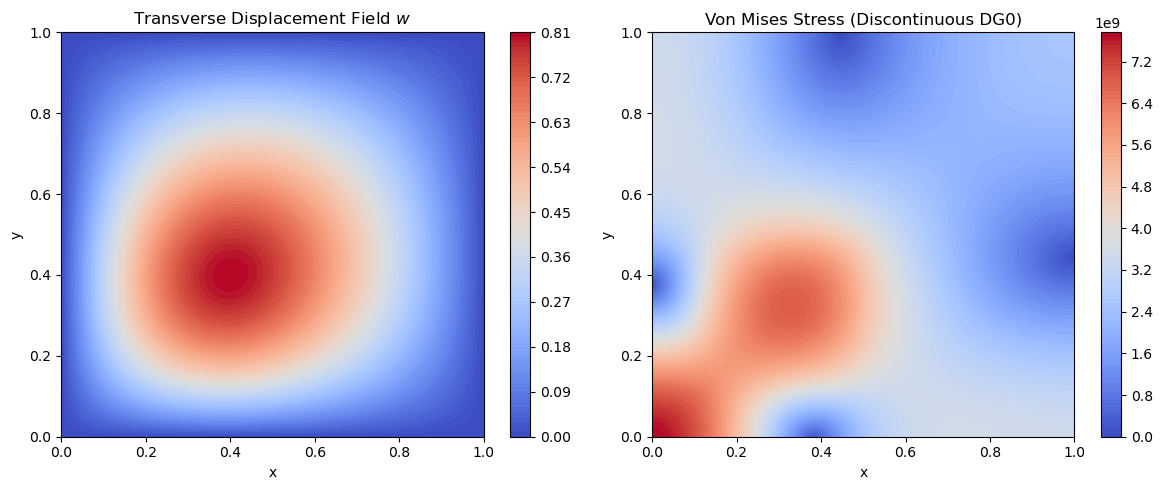

Saved Results_2025-04-14_14-21-53/VonMises_X_0_300-Y_0_300.jpg


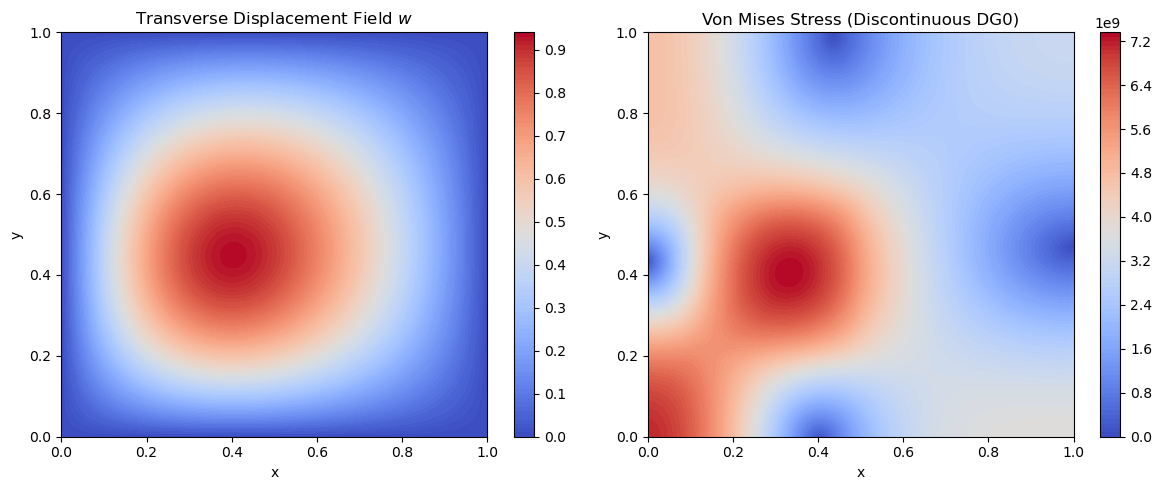

Saved Results_2025-04-14_14-21-53/VonMises_X_0_300-Y_0_400.jpg


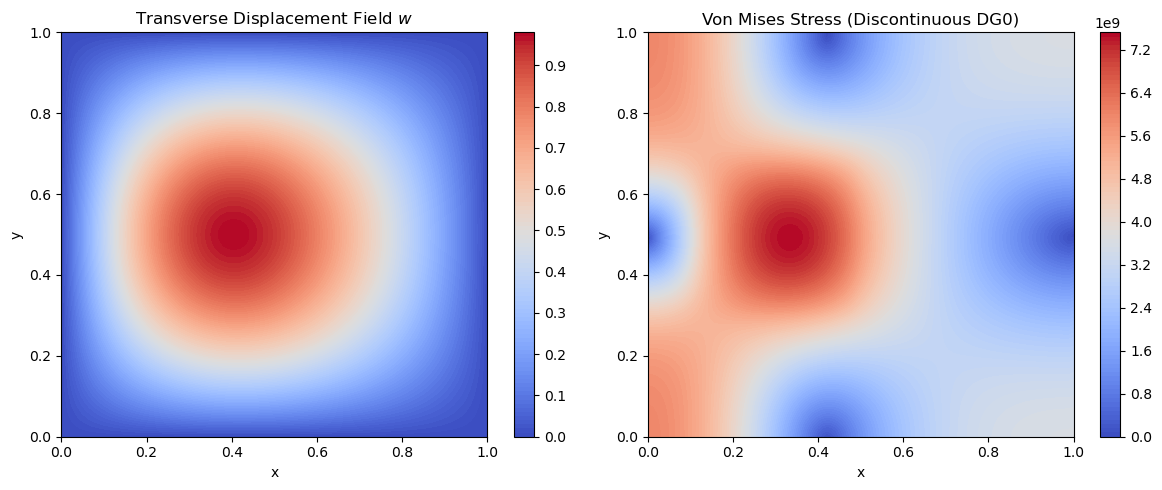

Saved Results_2025-04-14_14-21-53/VonMises_X_0_300-Y_0_500.jpg


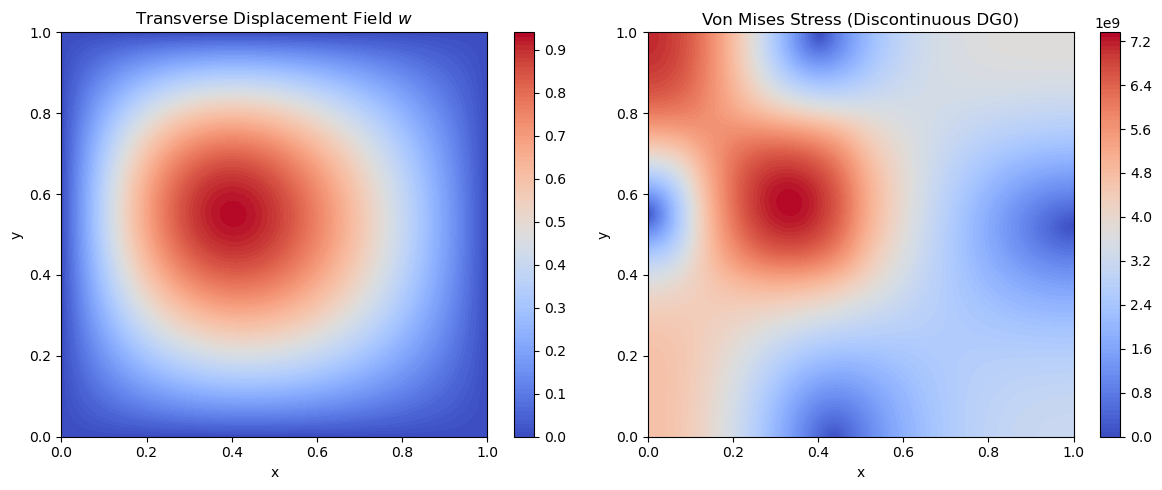

Saved Results_2025-04-14_14-21-53/VonMises_X_0_300-Y_0_600.jpg


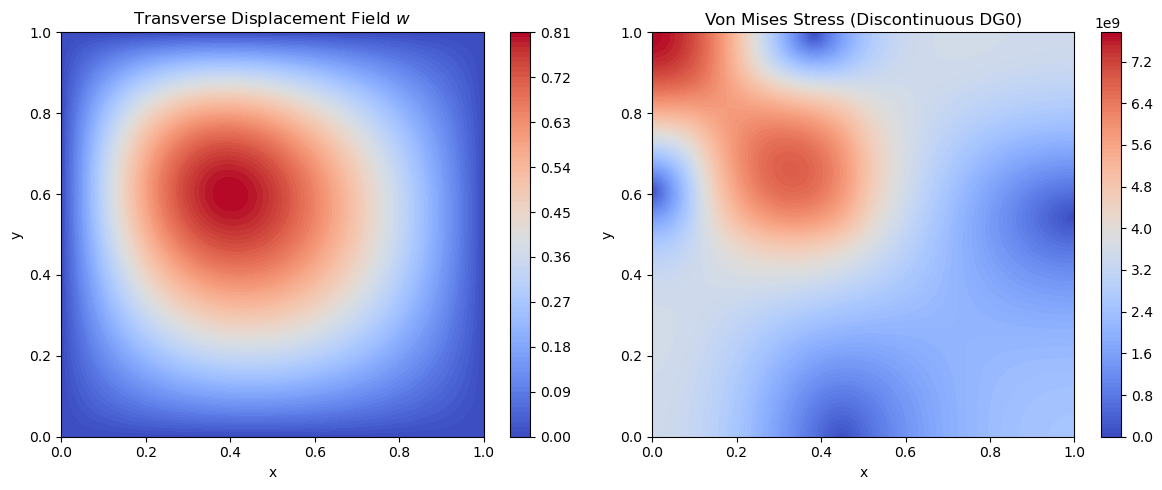

Saved Results_2025-04-14_14-21-53/VonMises_X_0_300-Y_0_700.jpg


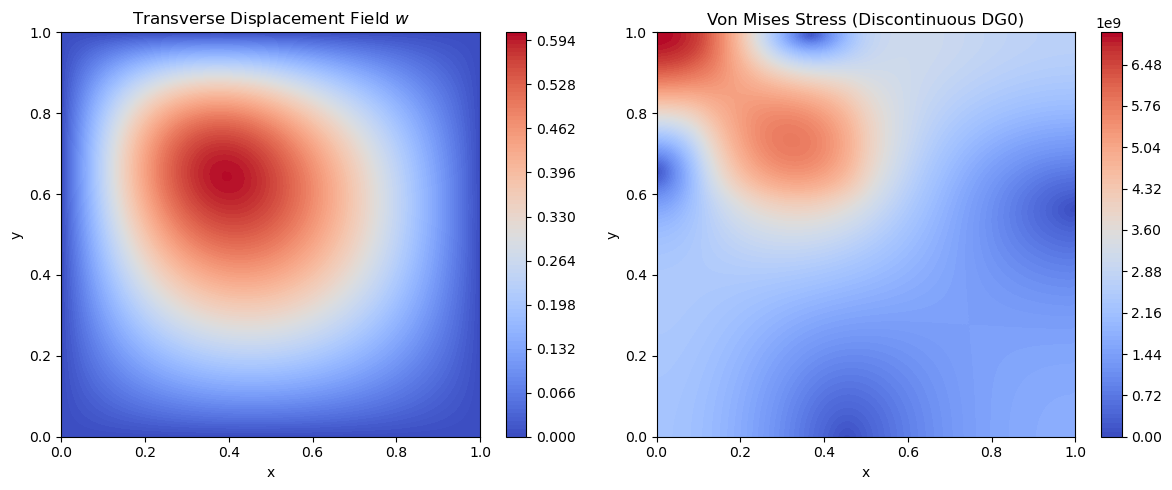

Saved Results_2025-04-14_14-21-53/VonMises_X_0_300-Y_0_800.jpg


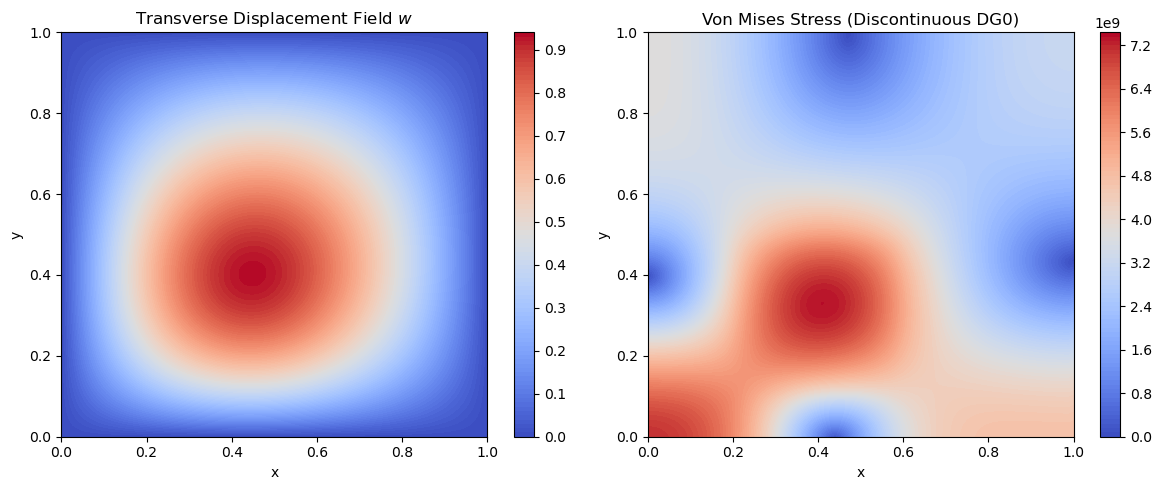

Saved Results_2025-04-14_14-21-53/VonMises_X_0_400-Y_0_300.jpg


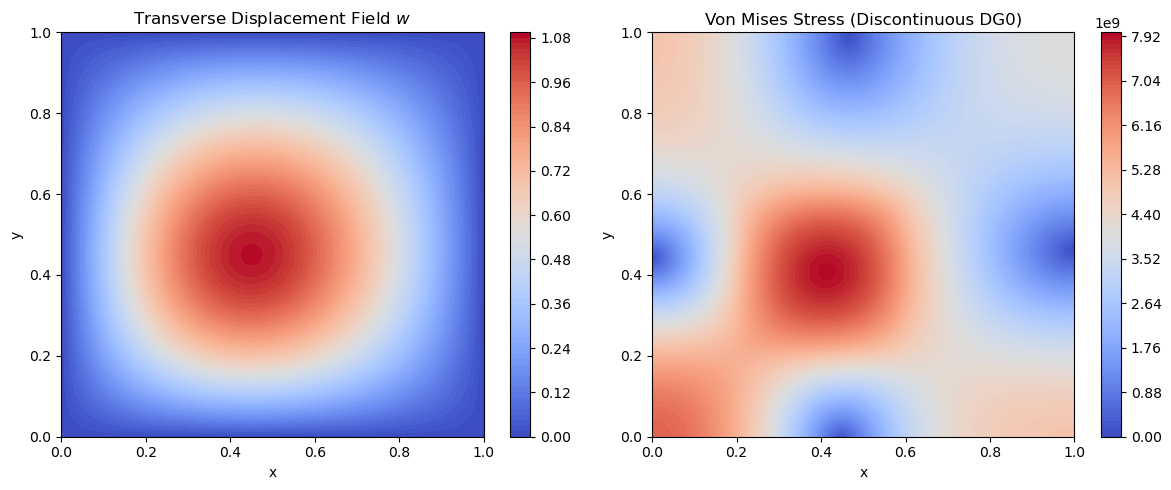

Saved Results_2025-04-14_14-21-53/VonMises_X_0_400-Y_0_400.jpg


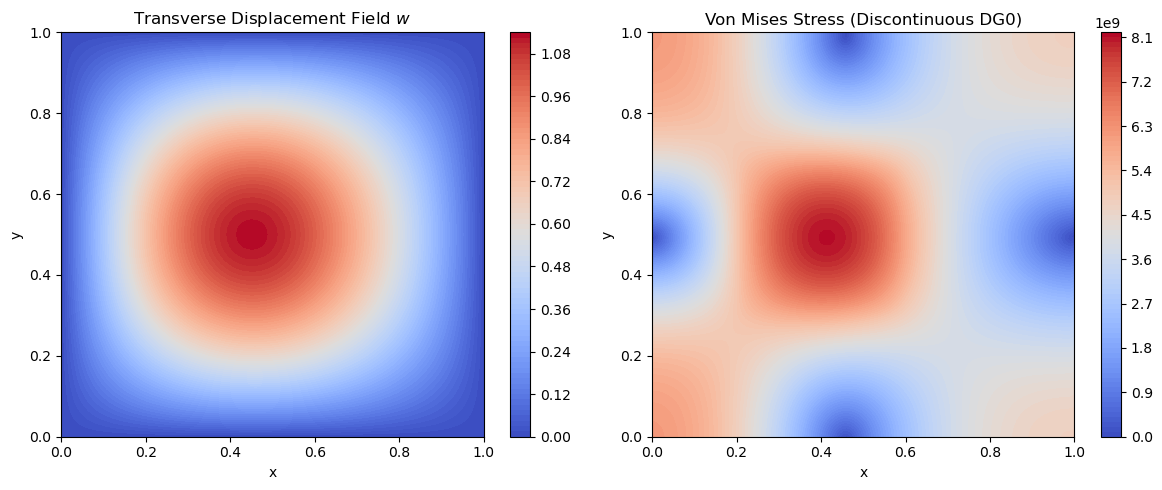

Saved Results_2025-04-14_14-21-53/VonMises_X_0_400-Y_0_500.jpg


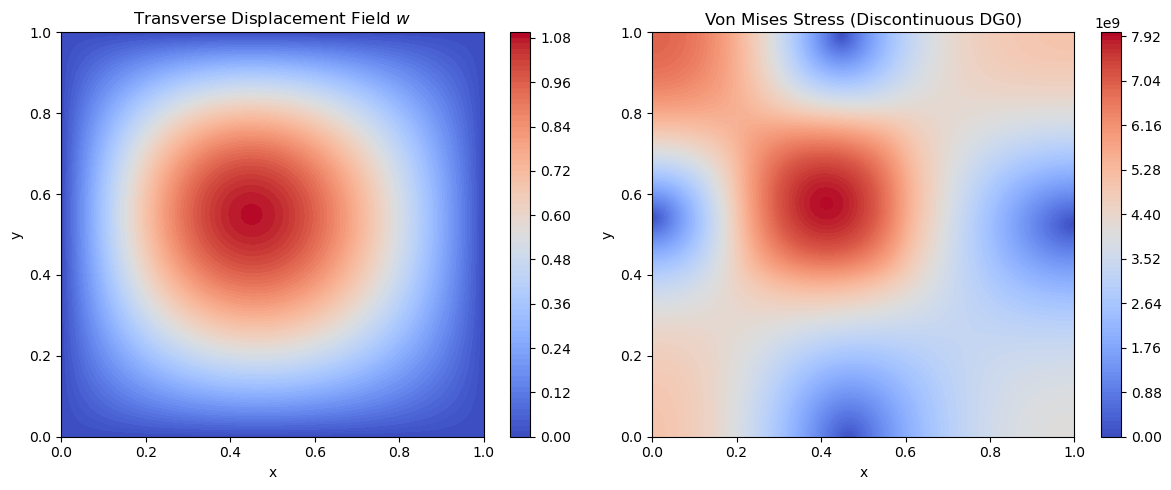

Saved Results_2025-04-14_14-21-53/VonMises_X_0_400-Y_0_600.jpg


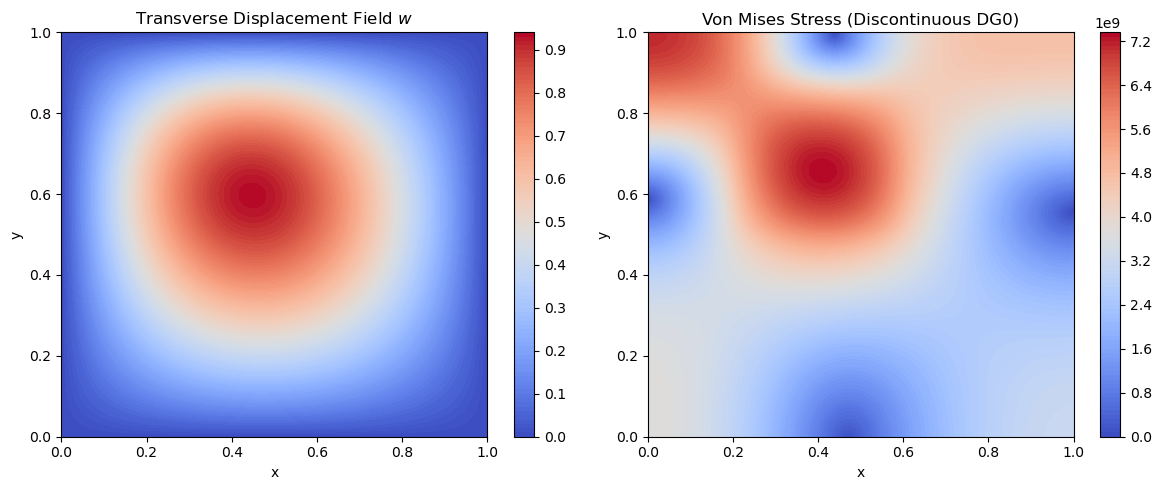

Saved Results_2025-04-14_14-21-53/VonMises_X_0_400-Y_0_700.jpg


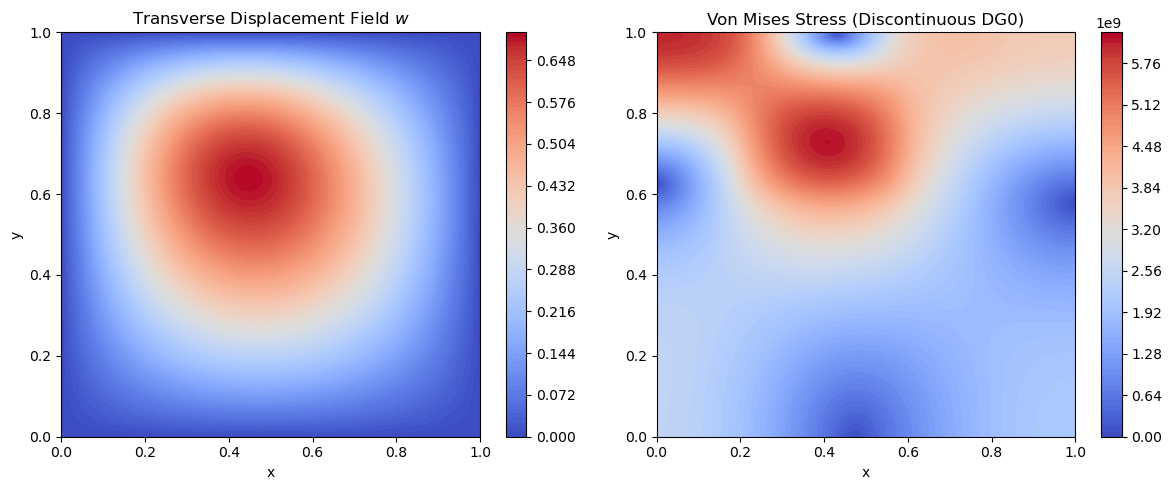

Saved Results_2025-04-14_14-21-53/VonMises_X_0_400-Y_0_800.jpg


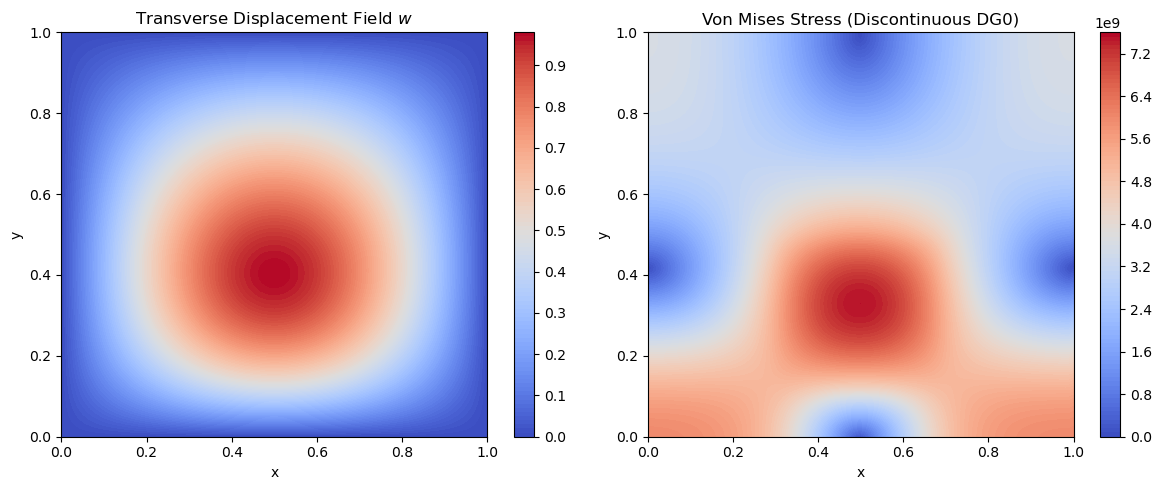

Saved Results_2025-04-14_14-21-53/VonMises_X_0_500-Y_0_300.jpg


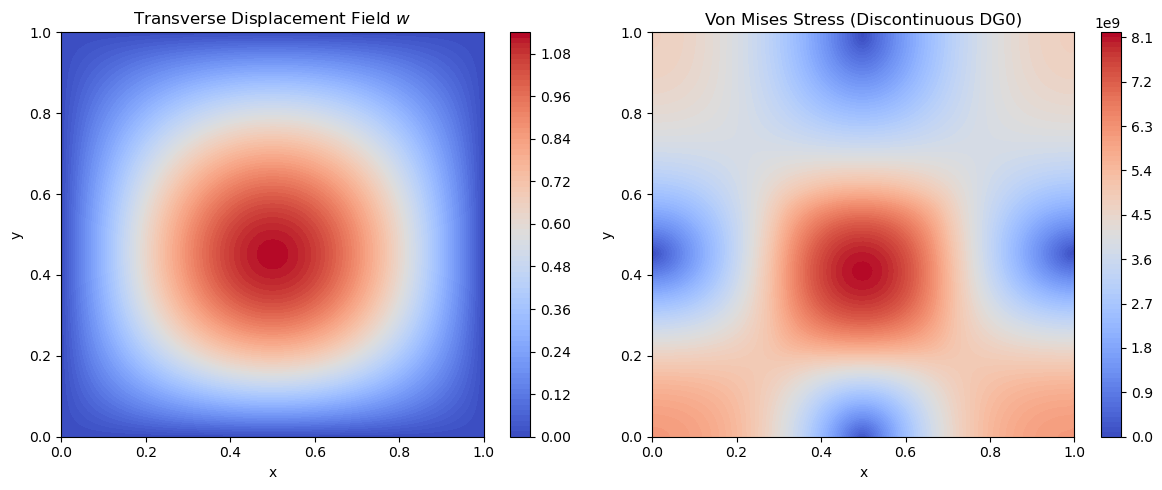

Saved Results_2025-04-14_14-21-53/VonMises_X_0_500-Y_0_400.jpg


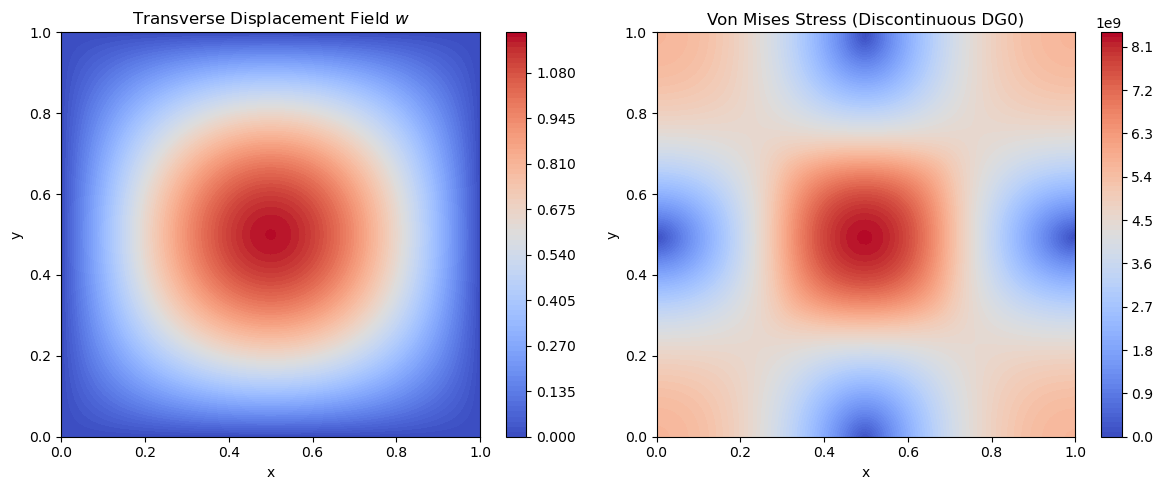

Saved Results_2025-04-14_14-21-53/VonMises_X_0_500-Y_0_500.jpg


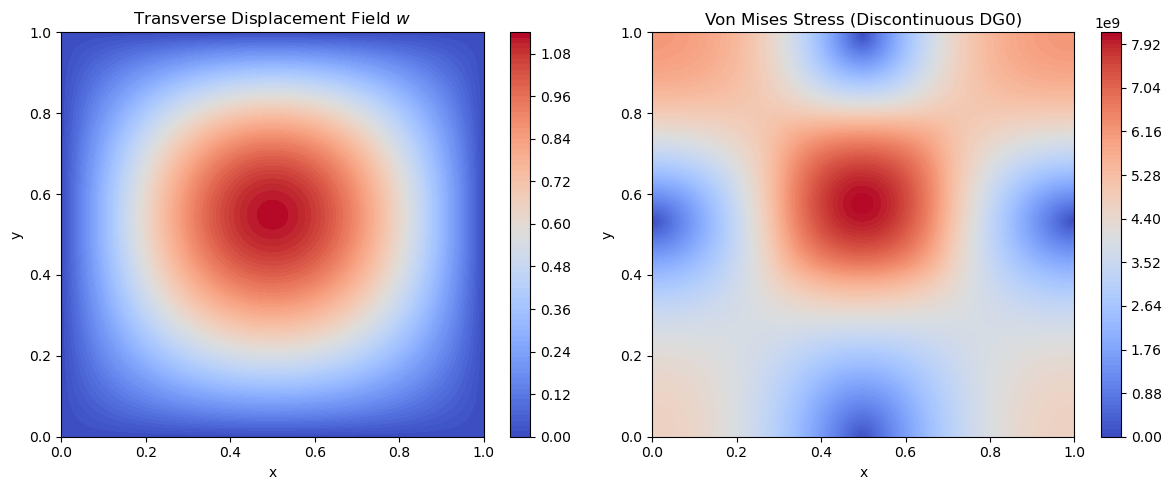

Saved Results_2025-04-14_14-21-53/VonMises_X_0_500-Y_0_600.jpg


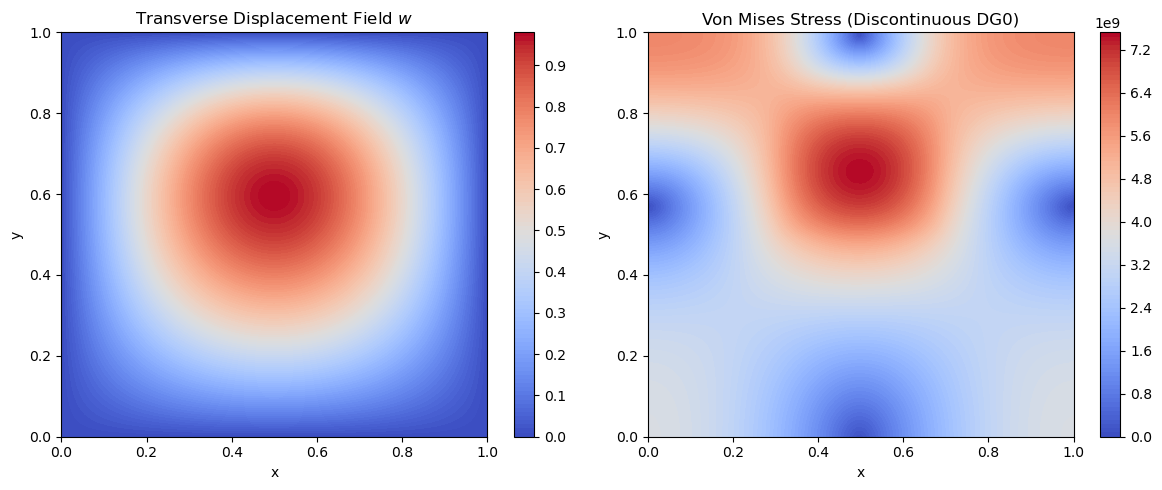

Saved Results_2025-04-14_14-21-53/VonMises_X_0_500-Y_0_700.jpg


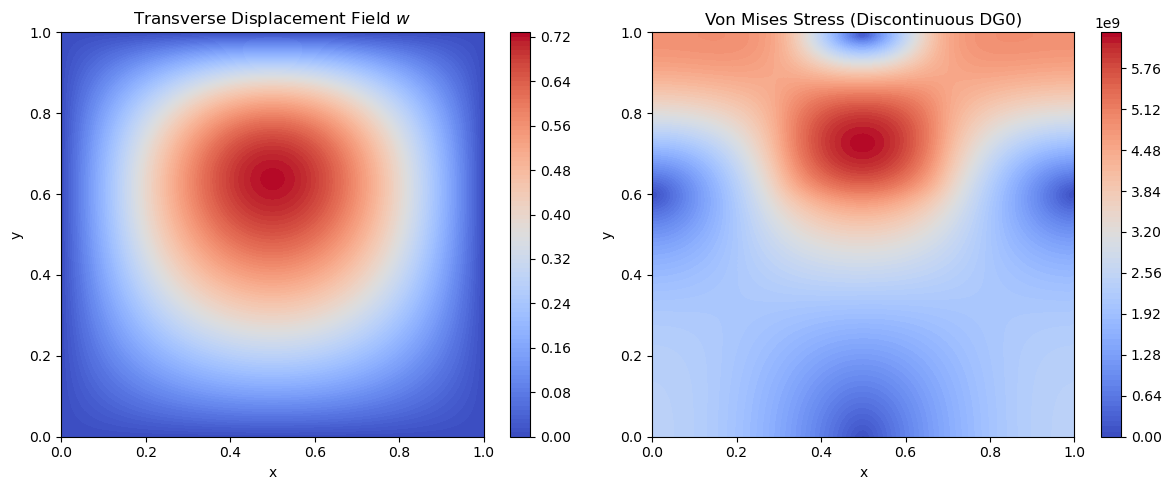

Saved Results_2025-04-14_14-21-53/VonMises_X_0_500-Y_0_800.jpg


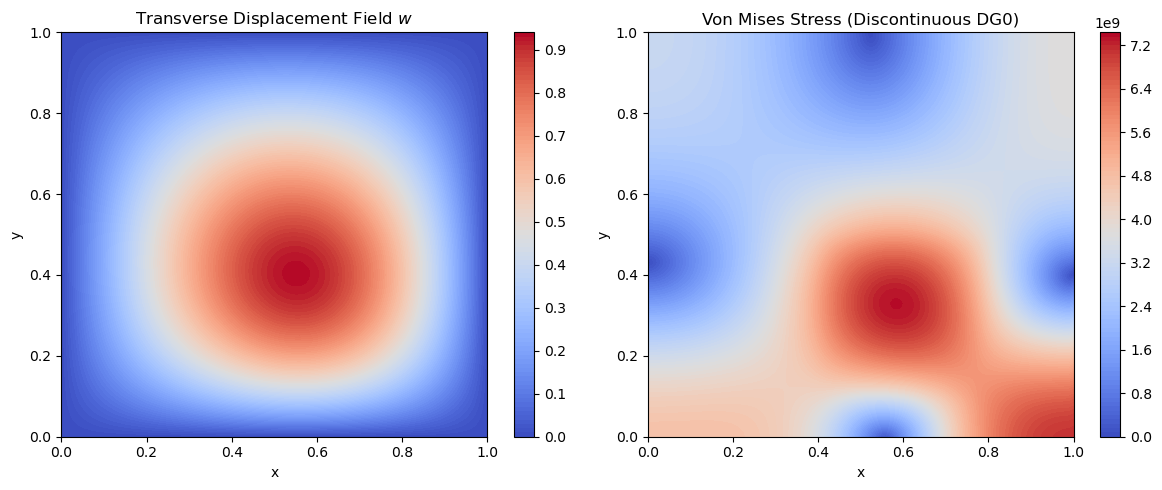

Saved Results_2025-04-14_14-21-53/VonMises_X_0_600-Y_0_300.jpg


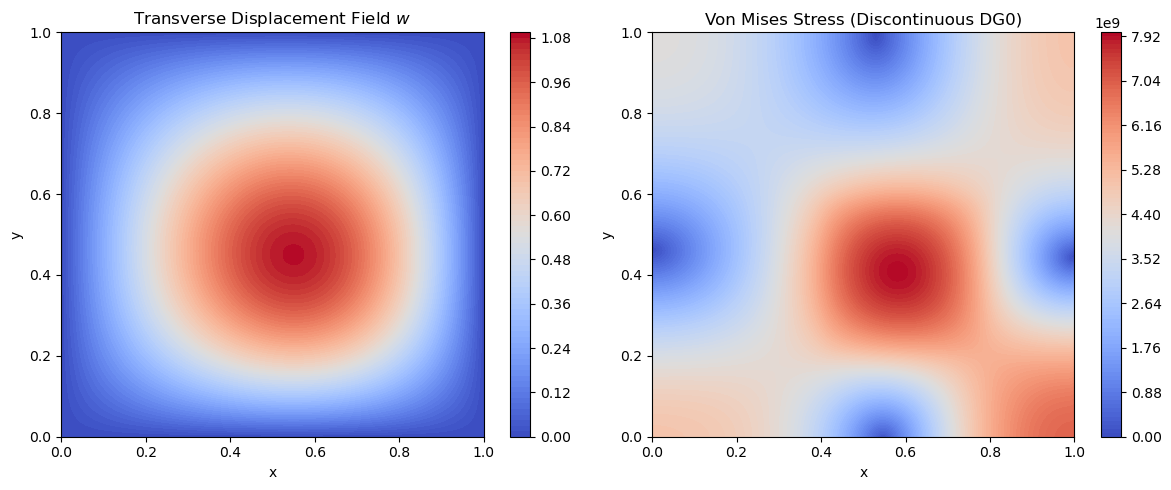

Saved Results_2025-04-14_14-21-53/VonMises_X_0_600-Y_0_400.jpg


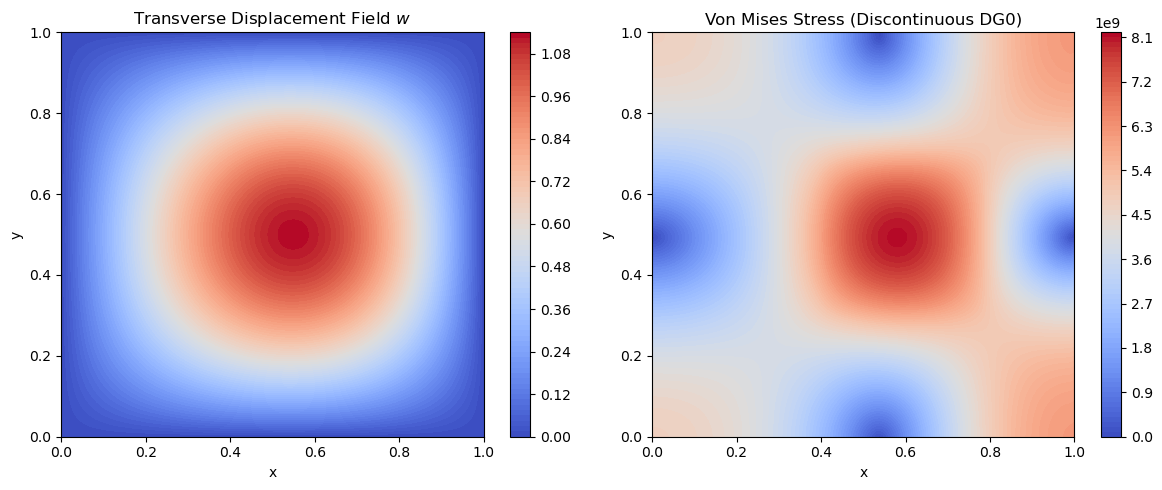

Saved Results_2025-04-14_14-21-53/VonMises_X_0_600-Y_0_500.jpg


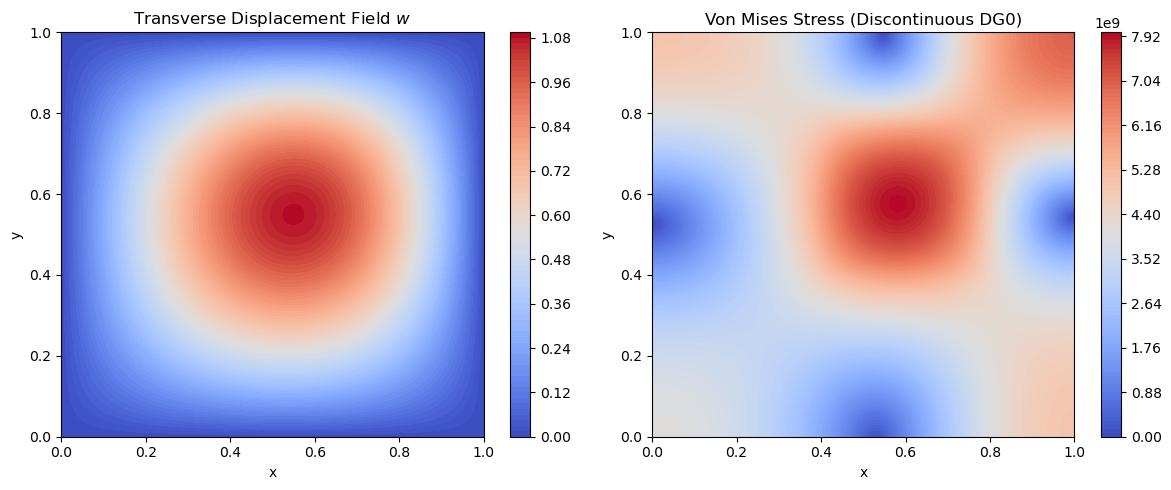

Saved Results_2025-04-14_14-21-53/VonMises_X_0_600-Y_0_600.jpg


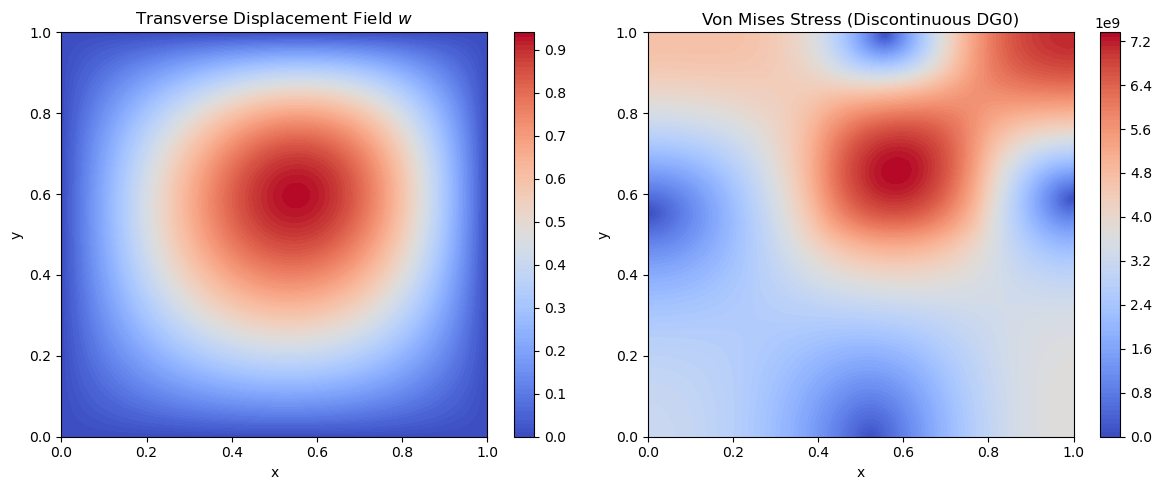

Saved Results_2025-04-14_14-21-53/VonMises_X_0_600-Y_0_700.jpg


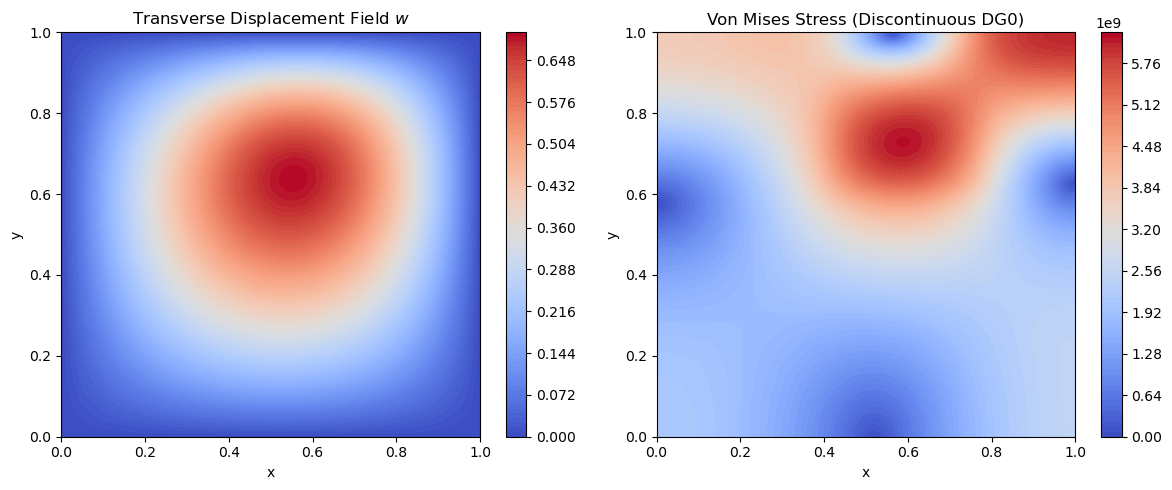

Saved Results_2025-04-14_14-21-53/VonMises_X_0_600-Y_0_800.jpg


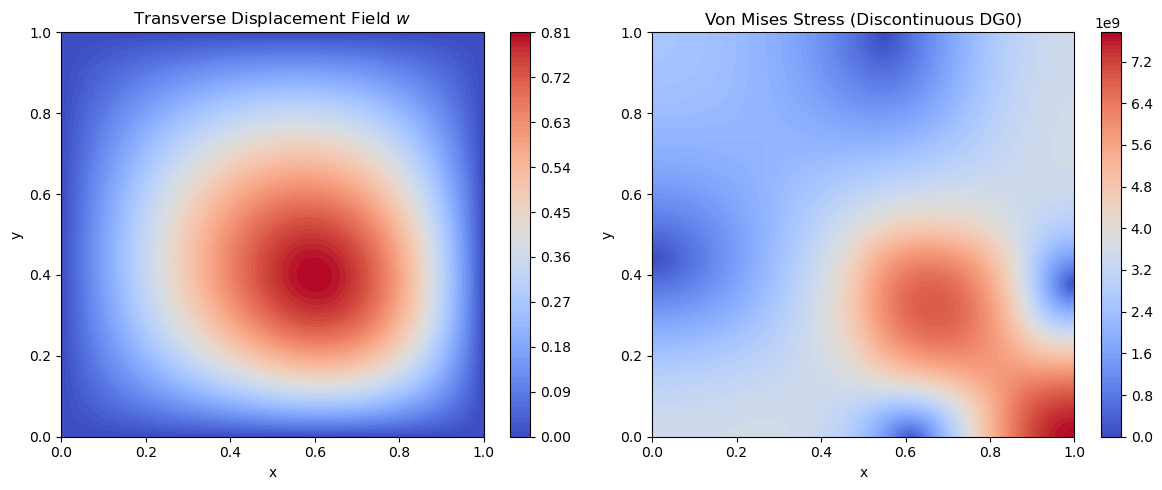

Saved Results_2025-04-14_14-21-53/VonMises_X_0_700-Y_0_300.jpg


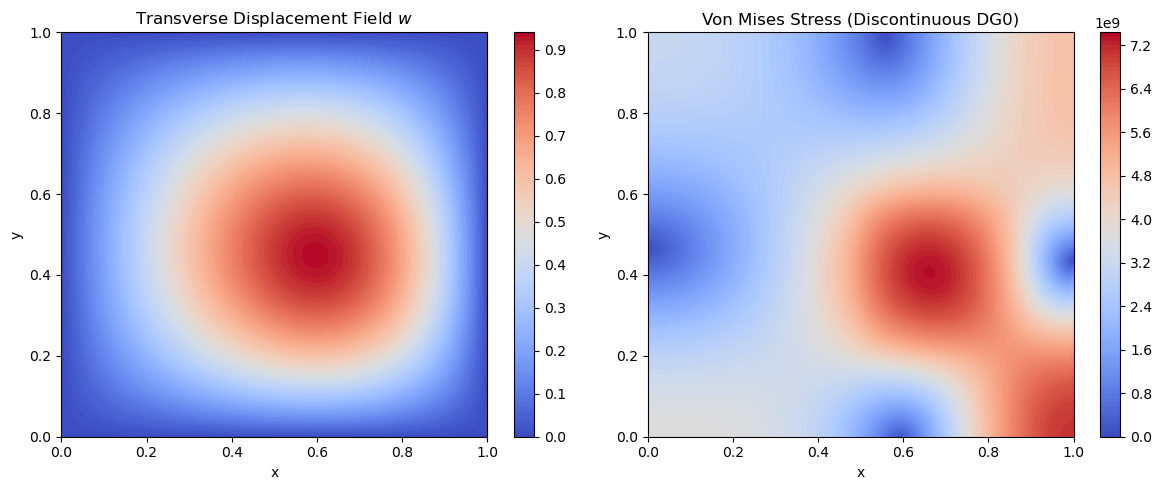

Saved Results_2025-04-14_14-21-53/VonMises_X_0_700-Y_0_400.jpg


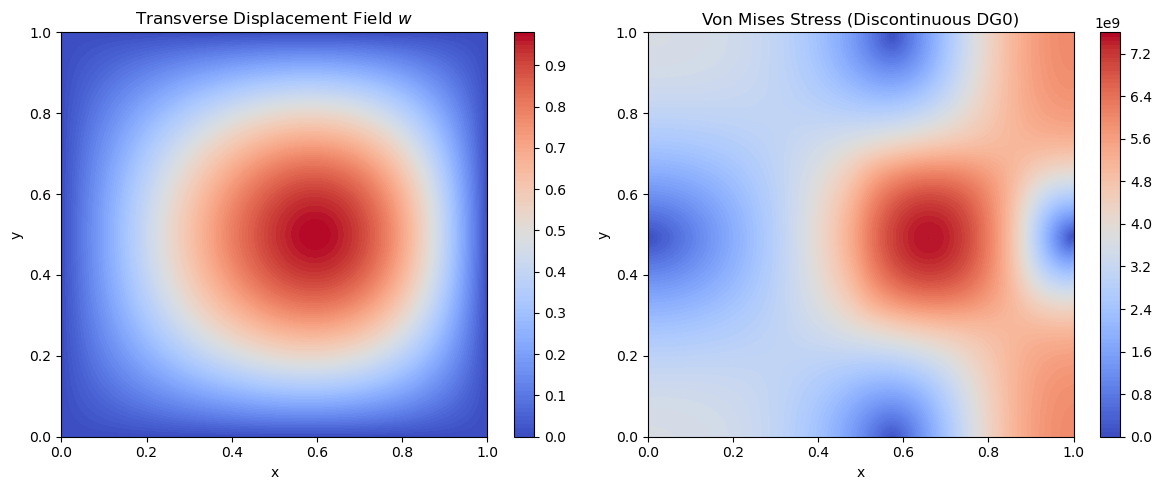

Saved Results_2025-04-14_14-21-53/VonMises_X_0_700-Y_0_500.jpg


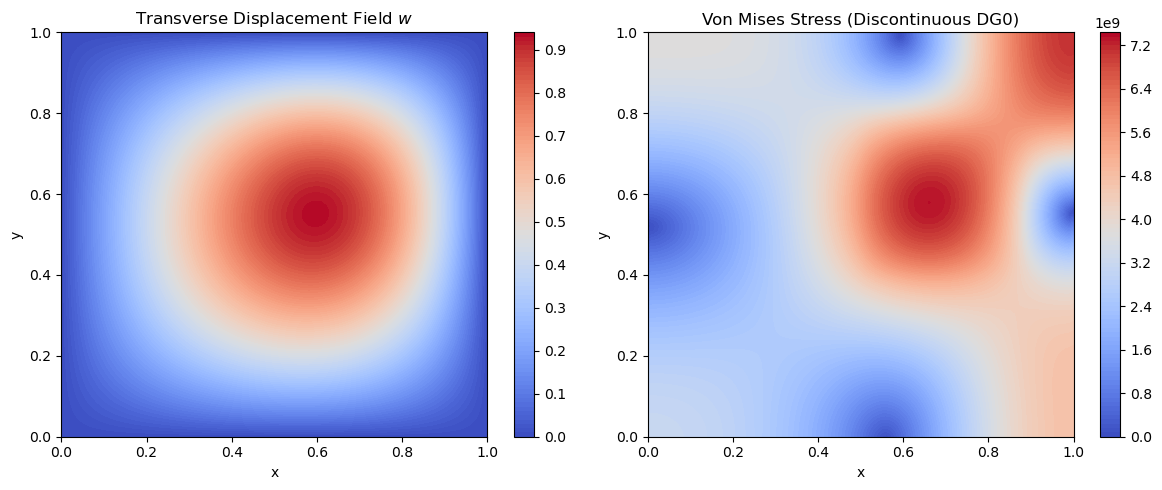

Saved Results_2025-04-14_14-21-53/VonMises_X_0_700-Y_0_600.jpg


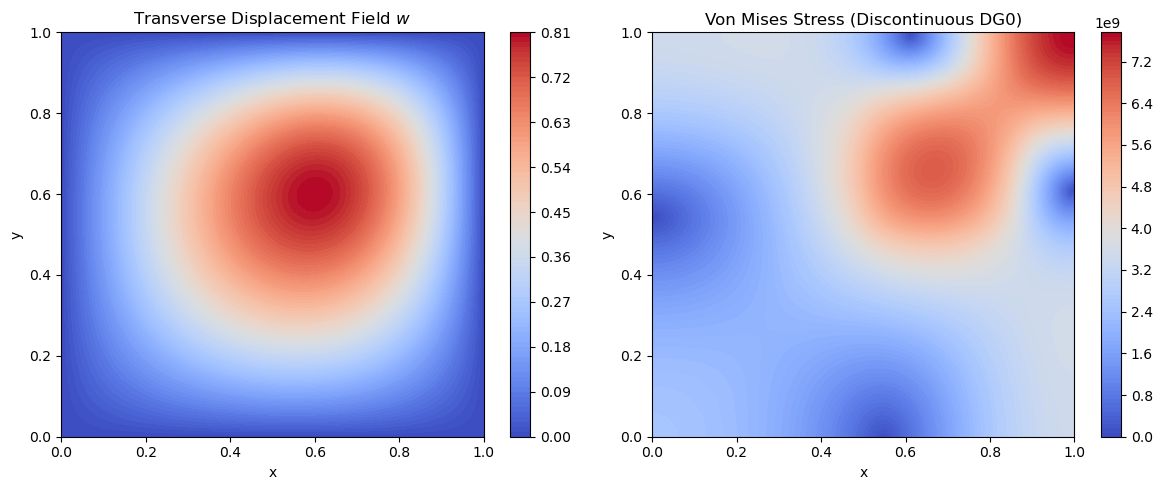

Saved Results_2025-04-14_14-21-53/VonMises_X_0_700-Y_0_700.jpg


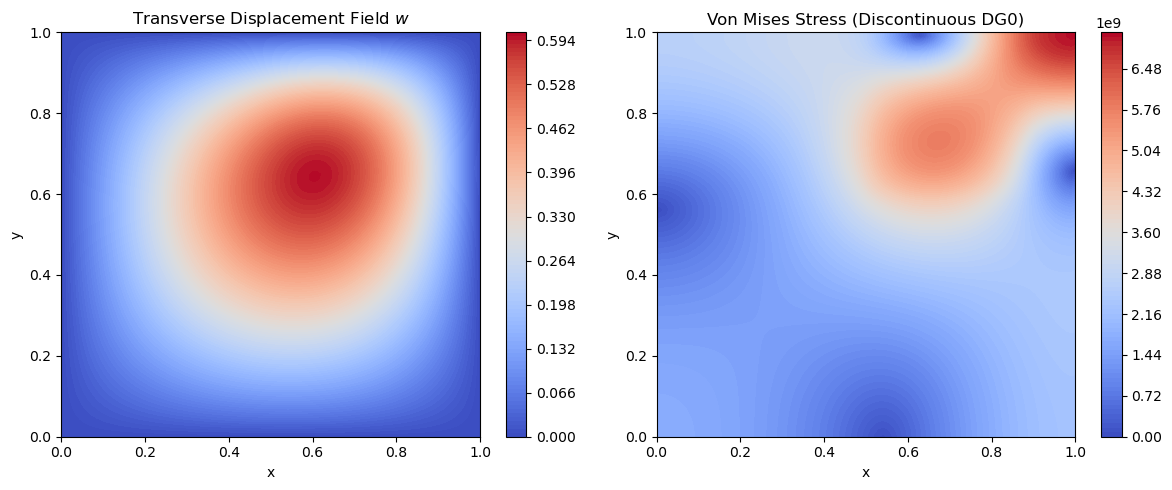

Saved Results_2025-04-14_14-21-53/VonMises_X_0_700-Y_0_800.jpg


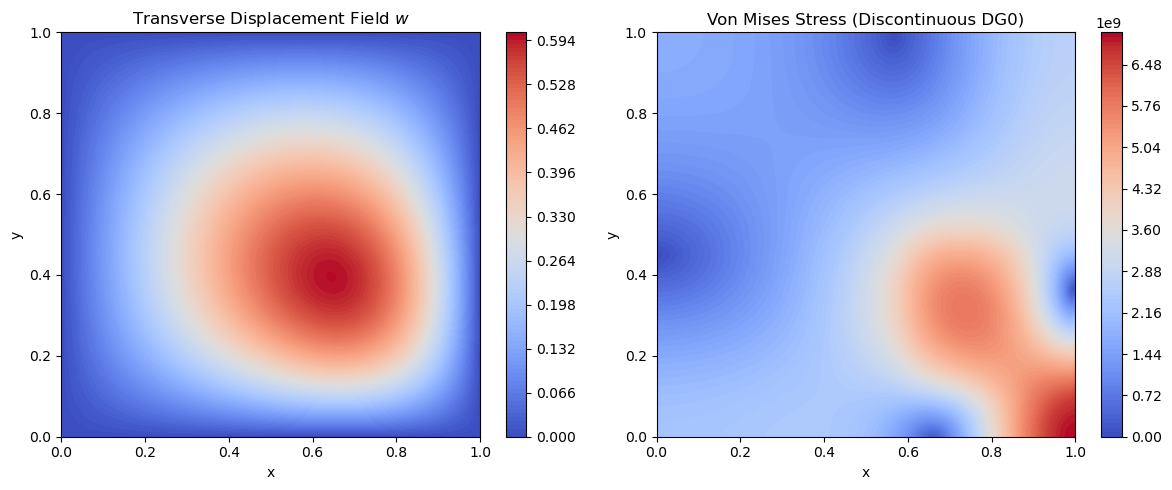

Saved Results_2025-04-14_14-21-53/VonMises_X_0_800-Y_0_300.jpg


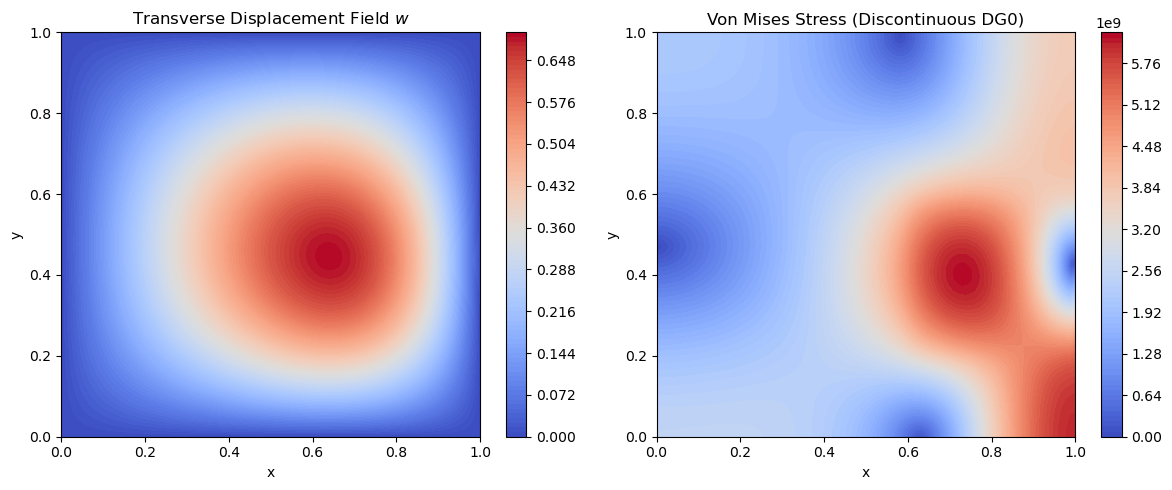

Saved Results_2025-04-14_14-21-53/VonMises_X_0_800-Y_0_400.jpg


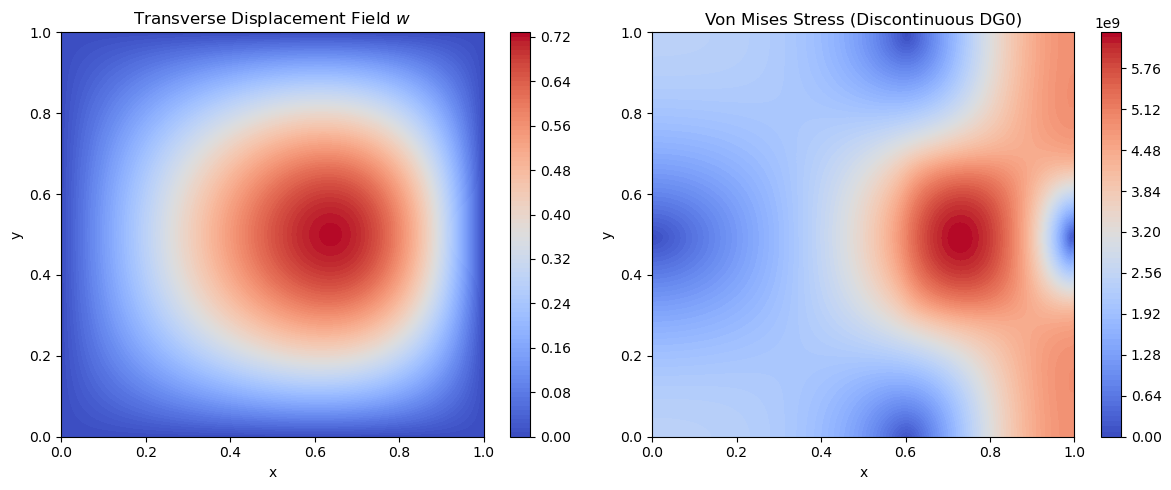

Saved Results_2025-04-14_14-21-53/VonMises_X_0_800-Y_0_500.jpg


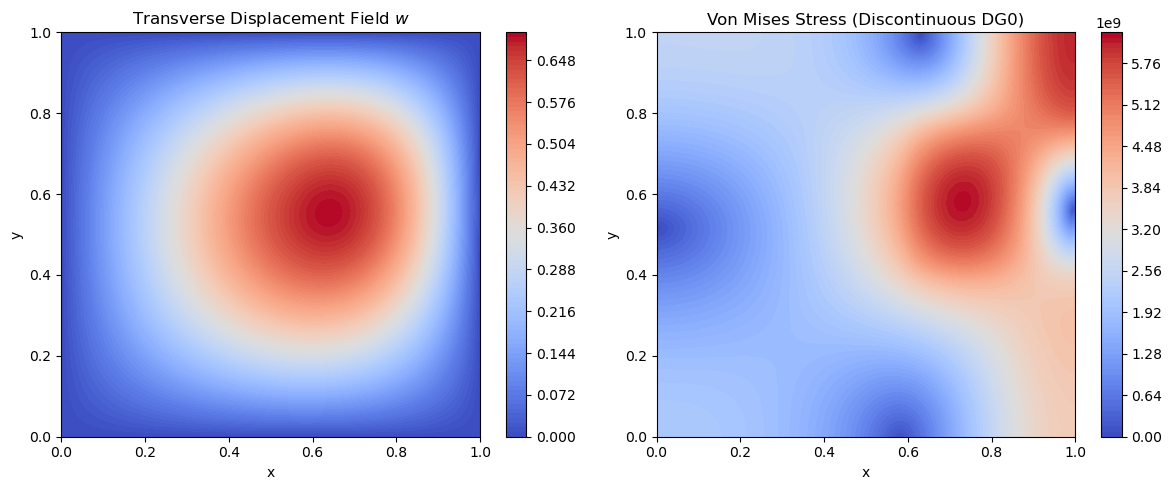

Saved Results_2025-04-14_14-21-53/VonMises_X_0_800-Y_0_600.jpg


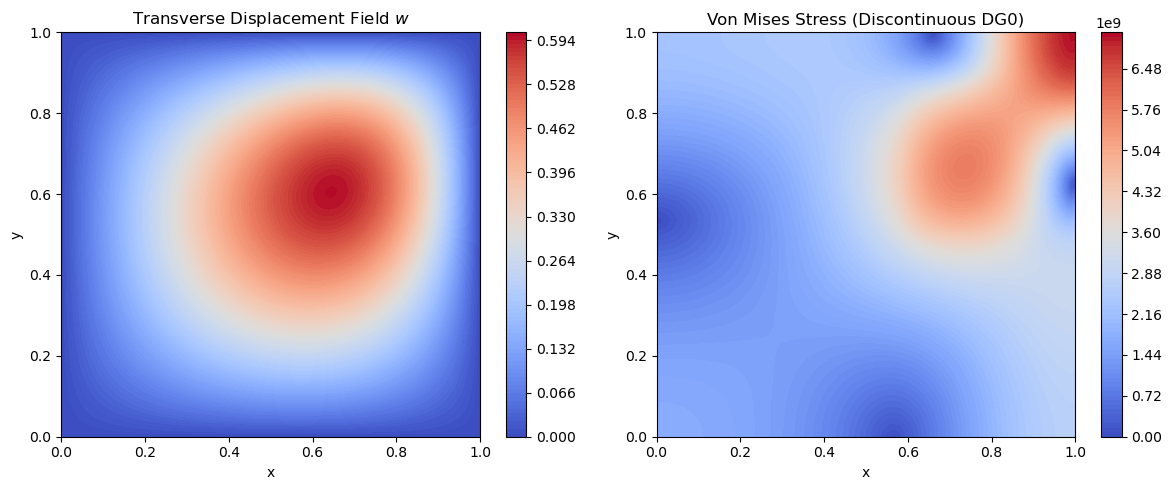

Saved Results_2025-04-14_14-21-53/VonMises_X_0_800-Y_0_700.jpg


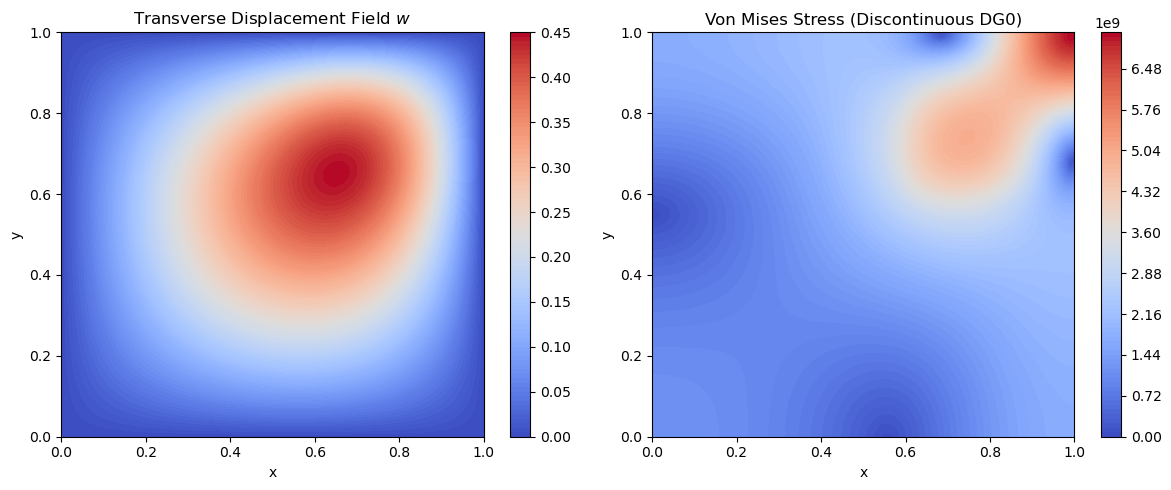

Saved Results_2025-04-14_14-21-53/VonMises_X_0_800-Y_0_800.jpg


In [6]:
# Create arrays of x and y coordinates for the loading points
x_coords_1 = np.around(np.arange(specimen_center_x, LoadingZone_end_x, LoadingSpacing), decimals=2)
x_coords_2 = np.around(np.arange(specimen_center_x - LoadingSpacing, LoadingZone_start_x, -1 * LoadingSpacing), decimals=3)
x_coords = np.concatenate((x_coords_1, x_coords_2))
x_coords = np.sort(x_coords).tolist()
y_coords_1 = np.around(np.arange(specimen_center_y, LoadingZone_end_y, LoadingSpacing), decimals=2)
y_coords_2 = np.around(np.arange(specimen_center_y - LoadingSpacing, LoadingZone_start_y, -1 * LoadingSpacing), decimals=3)
y_coords = np.concatenate((y_coords_1, y_coords_2))
y_coords = np.sort(y_coords).tolist()
#x_coords = [0.5]
#y_coords = [0.5]

# Get mesh coordinates and cell connectivity (moved outside the loop)
coords = mesh.coordinates()
cells = mesh.cells()

# Iterate over the loading points
for pressure_center_x in x_coords:
    for pressure_center_y in y_coords:
        # --- 변수 초기화 ---
        w_.assign(Constant(0.0))  # 변위 초기화
        # von_mises 초기화 (필요한 경우)

        # Define Loading Area SubDomain
        class LoadArea(SubDomain):
            def inside(self, x, on_boundary):
                # Returns True if the point x is within the loading area
                return (pressure_center_x - load_width/2.0 <= x[0] <= pressure_center_x + load_width/2.0 and
                        pressure_center_y - load_height/2.0 <= x[1] <= pressure_center_y + load_height/2.0)

        load_area = LoadArea()

        # Find vertices within the loading area
        vertex_values = W.tabulate_dof_coordinates() # Get the coordinates of all vertices
        load_vertices = []
        for i in range(vertex_values.shape[0]):
            x = vertex_values[i, :] # Get the coordinates of the i-th vertex
            if load_area.inside(x, False): # Check if the vertex is within the loading area (on_boundary is False)
                load_vertices.append(i) # Add the vertex index to the list of loading vertices

        # Calculate the force applied to each vertex
        if load_vertices:
            point_force = total_force / len(load_vertices) # Distribute the total force evenly among the loading vertices
        else:
            point_force = 0.0

        # Apply PointSource to each vertex within the loading area
        point_sources = []
        for vertex_index in load_vertices:
            x = vertex_values[vertex_index, :] # Get the coordinates of the vertex
            pt = Point(x[0], x[1]) # Create a Point object for the vertex
            ps = PointSource(W, pt, point_force) # Create a PointSource object at the vertex with the calculated force
            point_sources.append(ps) # Add the PointSource to the list

        # Define the total potential energy
        L = psi_M*dx + L_CDG

        # Derive the variational form and the Jacobian
        F = derivative(L, w_, w_t)
        J = derivative(F, w_, w)

        # --- 시스템 행렬 및 우변 벡터 재조립 ---
        A, b = assemble_system(J, -F, bcs=bcs)

        # Apply the point sources to the right-hand side vector
        for ps in point_sources:
            ps.apply(b)

        # Solve the linear system using a direct solver (MUMPS)
        solver = PETScLUSolver("mumps")
        solver.solve(A, w_.vector(), b)

        # Calculate and save Von Mises stress
        I = Identity(2) # Define the identity tensor
        theta_sol = grad(w_) # Calculate the gradient of the displacement
        k_sol = sym(grad(theta_sol)) # Calculate the curvature tensor
        M_sol = 2*D*((1.0 - nu)*k_sol + nu*tr(k_sol)*I) # Calculate the bending moment tensor

        # Calculate the Von Mises stress expression
        von_mises_expr = (6.0/t**2)*sqrt( M_sol[0,0]**2 - M_sol[0,0]*M_sol[1,1] + M_sol[1,1]**2 + 3*M_sol[0,1]**2 )

        # Project the Von Mises stress onto a DG0 space
        V0 = FunctionSpace(mesh, "DG", 0)
        von_mises = project(von_mises_expr, V0)

        # Create image file name (fill with zeros)
        x_str = f"{pressure_center_x:.3f}".replace('.', '_') # Format the x-coordinate as a string
        y_str = f"{pressure_center_y:.3f}".replace('.', '_') # Format the y-coordinate as a string
        filename = f"VonMises_X_{x_str}-Y_{y_str}.jpg" # Create the filename
        filepath = os.path.join(results_folder, filename) # Create the full file path

        # --- Create a figure with two subplots side by side ---
        fig, axes = plt.subplots(1, 2, figsize=(12, 5))  # 1 row, 2 columns

        # --- Displacement Plot (Left Subplot) ---
        plt.sca(axes[0])  # Select the first subplot
        displacement_vertex = w_.compute_vertex_values(mesh)
        plt.tricontourf(coords[:,0], coords[:,1], cells, displacement_vertex, 100, cmap='coolwarm')
        plt.colorbar()
        plt.title("Transverse Displacement Field $w$")
        plt.xlabel("x")
        plt.ylabel("y")

        # --- Von Mises Stress Plot (Right Subplot) ---
        plt.sca(axes[1])  # Select the second subplot
        von_mises_vertex = von_mises.compute_vertex_values(mesh)
        plt.tricontourf(coords[:,0], coords[:,1], cells, von_mises_vertex, 100, cmap='coolwarm')
        plt.colorbar()
        plt.title("Von Mises Stress (Discontinuous DG0)")
        plt.xlabel("x")
        plt.ylabel("y")

        plt.tight_layout() # Adjust the layout
        plt.savefig(filepath) # Save the figure to a file
        plt.show() # Display the figure
        plt.close() # Prevent memory leak by closing the figure

        print(f"Saved {filepath}") # Print the file path
